In [290]:
import numpy as np
import math
import struct
from pathlib import Path
import matplotlib.pyplot as plt
import copy
from PIL import Image,ImageFilter
from tqdm import tqdm_notebook

In [291]:
#通過截圖得到圖片進行預處理
def ImagePrepare(Img):
    img=Image.open('./image/'+str(Img)+'.png')
    plt.imshow(img)
    data=list(img.getdata())
    result=[(255-x)*1.0/255.0 for x in data]
    return np.array(result)

In [292]:
#導入資料集
dataset_path = Path('./Mnist')
train_img_path = dataset_path/'train-images.idx3-ubyte'
train_labels_path = dataset_path/'train-labels.idx1-ubyte'
test_img_path = dataset_path/'t10k-images.idx3-ubyte'
test_labels_path = dataset_path/'t10k-labels.idx1-ubyte'

In [293]:
train_num=50000
valid_num=10000
test_num=10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    temp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255
    train_img=temp_img[:train_num]
    valid_img=temp_img[train_num:]

with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255

with open(train_labels_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    temp_label=np.fromfile(f,dtype=np.uint8)
    train_label=temp_label[:train_num]
    valid_label=temp_label[train_num:]

with open(test_labels_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_label=np.fromfile(f,dtype=np.uint8)

#img=train_img[0].reshape(28,28)
#plt.imshow(img,cmap='gray')
#plt.show()

In [294]:
#啟動函數
def Relu(x):
    return np.where(x>0,x,0.0001)

#啟動函數
def tanh(x):
    return np.tanh(x)
#啟動函數
def softmax(x):
    exp=np.exp(x-x.max())
    return exp/exp.sum()

#啟動函數的調用
activation=[Relu,tanh,softmax]

#預設參數 
dimensions=[28*28,100,10] #輸入圖片的大小為1*(28*28),經過第一層後變為1*10的矩陣

distribution=[
    {},
    {'b':[0,0],'w':[-math.sqrt( 6/(dimensions[0]+dimensions[1]) ),math.sqrt( 6/(dimensions[0]+dimensions[1]) )]},
    {'b':[0,0],'w':[-math.sqrt( 6/(dimensions[1]+dimensions[2]) ),math.sqrt( 6/(dimensions[1]+dimensions[2]) )]},
]

In [295]:
#啟動函數的導數
def d_Relu(data):
    return np.where(x>0,1,0.0001)

def d_softmax(data):
    temp=softmax(data)
    return np.diag(temp)-np.outer(temp,temp)

def d_tanh(data):
    #return np.diag(1/(np.cosh(data))**2)
    return 1/(np.cosh(data)**2)
    #加速運算優化不用對角矩陣

#啟動函數的導數的調用
differential={Relu:d_Relu,softmax:d_softmax,tanh:d_tanh}
diff_type={Relu:'times',softmax:'dot',tanh:'times'}

In [296]:
#初始化
def init_parameters_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]

def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]

def init_parameters():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    #print(parameter)
    return parameter

In [297]:
parameters=init_parameters()

In [298]:
#處理圖片資料並輸出預測
def predict(img,parameters):
    layer_in=img
    layer_out=activation[0](layer_in)
    layer_in_list=[layer_in]
    layer_out_list=[layer_out]
    for layer in range(1,len(dimensions)):
        layer_in=np.dot(layer_out_list[layer-1],parameters[layer]['w'])+parameters[layer]['b']
        layer_out=activation[layer](layer_in)
        layer_in_list.append(layer_in)
        layer_out_list.append(layer_out)
    
    #return {'layer0_in':layer0_in,'layer0_out':layer0_out,'layer1_in':layer1_in,'layer1_out':layer1_out}
    return {'layer_out':layer_out_list,'layer_in':layer_in_list}

#獲得預測答案
def get_answer(img,parameters):
    return predict(img,parameters)['layer_out'][-1].argmax()

In [299]:
#onehot生成正確結果矩陣y
onehot=np.identity(dimensions[-1])

#定義損失函數 loss founction=(y-ypred)^2 其中y和ypred都是1*10的矩陣向量 會導致局部最優解 
def sqr_loss(img,label,parameters):
    y_pred=predict(img,parameters)['layer_out'][-1]
    y=onehot[label]
    diff=y-y_pred
    return np.dot(diff,diff)

In [300]:
#定義計算損失函數對參數b,w求導得到每一層的dJ/dw and dJ/db
#grad_parameters(train_img[2],train_label[2],init_parameters())
def grad_parameters(img,label,parameters):

    InOut=predict(img,parameters)

    #diff_layer 這裡是“da[2]”=dJ/da[2]
    diff_layer= -2*(onehot[label]-InOut['layer_out'][-1])
    
    grad_result=[None]*len(dimensions)

    #每一層的w和dJ/dw,b和dJ/db的維度都是相同的
    
    for layer in range(len(dimensions)-1,0,-1):
        if diff_type[activation[layer]]=='times':
            diff_layer=differential[activation[layer]](InOut['layer_in'][layer])*diff_layer
            #dz[layer]=da[layer]*g[layer]'(z[layer])
            #這裡用*本來是應該變成對角矩陣用點乘 優化加速後用同維度矩陣逐個元素相乘

        if diff_type[activation[layer]]=='dot':
            diff_layer=np.dot(differential[activation[layer]](InOut['layer_in'][layer]),diff_layer)
            #dz[layer]=g[layer]'(z[layer]) dot da[layer]
            #這裡用點乘是因為dsoftmax求導後產生對角矩陣變為[10,10] dot [10,1]

        grad_result[layer]={}

        grad_result[layer]['b']=diff_layer
        #db[layer]=dz[layer]

        grad_result[layer]['w']=np.outer(InOut['layer_out'][layer-1],diff_layer)
        #dw[layer]=np.rot90(dz[layer]) dot a[layer-1] = a[layer-1] outer dz[layer]
        #將一維矩陣旋轉90度 即(1,784) -> (784,1)
        #(784,1) dot (1,100) = (1,784) outer (1,100) =(784,100) 兩種計算含義相同
        
        diff_layer=np.dot(parameters[layer]['w'],diff_layer)
        #da[layer-1]=w[layer].T dot dz[layer]
    
    return grad_result

In [301]:
#計算訓練模型精確度
def valid_loss(parameters):
    loss_accu=0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(valid_img[img_i],valid_label[img_i],parameters)
    return loss_accu/(valid_num/10000)

def valid_accuracy(parameters):
    correct=[predict(valid_img[img_i],parameters)['layer_out'][-1].argmax()==valid_label[img_i] for img_i in range(valid_num)]
    # print('validation accuracy : ',correct.count(True)/len(correct))
    return correct.count(True)/len(correct)

def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(train_img[img_i],train_label[img_i],parameters)
    return loss_accu/(train_num/10000)

def train_accuracy(parameters):
    correct=[predict(train_img[img_i],parameters)['layer_out'][-1].argmax()==train_label[img_i] for img_i in range(train_num)]
    #print('validation accuracy : ',correct.count(True)/len(correct))
    return correct.count(True)/len(correct)

In [302]:
#訓練神經網路模型
#batch_size 將所有訓練樣本劃分成多個batch

#grad_add和grad_divide用於train_batch函數
def grad_add(grad1,grad2):
    for layer in range(1,len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname]+=grad2[layer][pname]
    return grad1

def grad_divide(grad,denominator):
    for layer in range(1,len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname]/=denominator
    return grad

In [303]:
#訓練一個batch大小的train集合
#逐個樣本進行訓練 
batch_size=100
def train_batch(current_batch,parameters):
    grad_accu=grad_parameters(train_img[current_batch*batch_size+0],train_label[current_batch*batch_size+0],parameters)
    for img_i in range(1,batch_size):
        grad_temp=grad_parameters(train_img[current_batch*batch_size+img_i],train_label[current_batch*batch_size+img_i],parameters)
        grad_add(grad_accu,grad_temp)
        #for key in grad_accu.keys():
        #    grad_accu[key]+=grad_temp[key]
    grad_divide(grad_accu,batch_size)
    #for key in grad_accu.keys():
    #    grad_accu[key]/=batch_size
    return grad_accu

#更新parameters
def combine_parameters(parameters,grad,learn_rate):
    parameter_temp=copy.deepcopy(parameters)
    parameter_temp=parameters
    
    for layer in range(len(parameter_temp)):
        for pname in parameter_temp[layer].keys():
            parameter_temp[layer][pname]-=learn_rate*grad[layer][pname]
    
    return parameter_temp

In [304]:
combine_parameters(parameters,train_batch(0,parameters),1)

[{},
 {'b': array([ 2.36460710e-03, -5.23536074e-04, -4.10906991e-03,  1.61026843e-03,
          4.06468988e-03,  2.32481201e-03,  4.23254846e-03, -3.28703763e-03,
          2.76555981e-03, -2.94107760e-03, -2.03913804e-03, -8.14837100e-04,
         -3.21994089e-06,  1.83922678e-04,  4.60881171e-04,  3.54860792e-03,
          1.90300912e-03,  3.57223688e-03, -1.92070918e-03, -4.62371860e-03,
         -2.09023038e-03,  2.18001100e-03,  3.14558928e-03, -7.70005616e-04,
         -7.05298267e-03,  3.92514585e-03,  7.27505285e-03, -4.94743257e-03,
          4.17384549e-03, -3.51773373e-03, -4.06471900e-03, -2.57856117e-03,
         -5.16070134e-04,  3.18098230e-03,  3.33036088e-03, -6.16228117e-03,
         -4.11691033e-03, -8.39751435e-04,  3.86862943e-03,  2.80621496e-03,
         -7.38701985e-04, -6.81408626e-03, -3.22559329e-03,  4.74445323e-04,
          3.33303385e-03,  3.03898100e-03,  3.89507922e-03, -4.11921072e-03,
         -3.35419719e-03, -4.29909649e-04, -5.18704167e-03, -4.932

In [305]:
parameters=init_parameters()
current_epoch=0
train_loss_list=[]
valid_loss_list=[]
train_accu_list=[]
valid_accu_list=[]

In [306]:
valid_accuracy(parameters)

0.1348

In [307]:
learn_rate=10**-0.6
epoch_num=10 #反復訓練次數

def train_epoch():
    for epoch in tqdm_notebook(range(epoch_num)):
        #print('running epoch {}/{}'.format(epoch+1,epoch_num))
        for i in range(train_num//batch_size):
            # if i%100==99:
            #     print('running batch {}/{}'.format(i+1,train_num//batch_size))
            global parameters
            grad_temp=train_batch(i,parameters)
            parameters=combine_parameters(parameters,grad_temp,learn_rate)
        train_loss_list.append(train_loss(parameters))
        train_accu_list.append(train_accuracy(parameters))
        valid_loss_list.append(valid_loss(parameters))
        valid_accu_list.append(valid_accuracy(parameters))
valid_accuracy(parameters)
train_epoch()
valid_accuracy(parameters)

C:\Users\Dian Li Blake\AppData\Local\Temp\ipykernel_37148\3889494575.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch_num)):


  0%|          | 0/10 [00:00<?, ?it/s]

0.9656

In [308]:
#觀察學習率與正確率的關係
def LearnRate():
    rand_batch=np.random.randint(train_num//batch_size)
    grad_parameter=train_batch(rand_batch,parameters)

    LearnRate_list=[]

    lower=-1
    upper=2
    step=0.1
    Power=[lower+step*i for i in range(int((upper-lower)//step)) ]
    for power in Power:
        learnrate=10**power
        parameters_temp=combine_parameters(parameters,grad_parameter,learnrate)
        train_loss_temp=train_loss(parameters_temp)
        LearnRate_list.append([power,train_loss_temp])

    plt.plot(np.array(LearnRate_list)[:,0],np.array(LearnRate_list)[:,1],color='red',label='LearnRate-Loss')
    plt.show()

print(softmax(np.array([1,2,3,4])))

[0.0320586  0.08714432 0.23688282 0.64391426]


In [309]:
#定義圖片展示函數
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    plt.show()
    print('label:',train_label[index])

def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    plt.show()
    print('label:',test_label[index])

def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    plt.show()
    print('label:',valid_label[index])

In [310]:
# #初始化+計算正確率+訓練+計算正確率
# parameters = init_parameters()
# valid_accuracy(parameters)
# train_epoch()
# valid_accuracy(parameters)

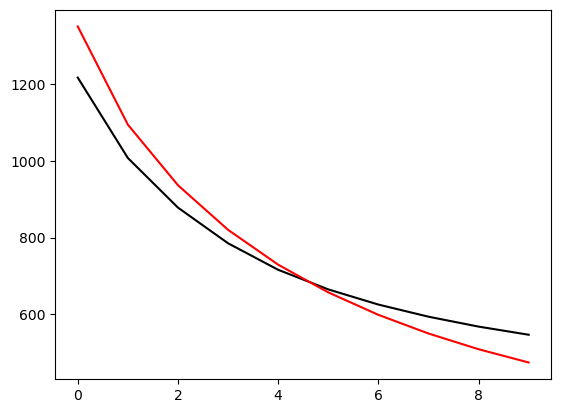

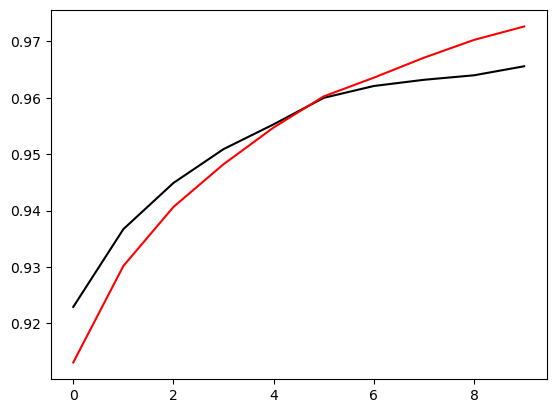

In [311]:
#視覺化訓練效果
#對比驗證集和訓練集的正確率和損失
lower=-20
plt.plot(valid_loss_list[lower:],color='black',label='ValidLoss')
plt.plot(train_loss_list[lower:],color='red',label='TrainLoss')
plt.show()

plt.plot(valid_accu_list[lower:],color='black',label='ValidAccu')
plt.plot(train_accu_list[lower:],color='red',label='TrainAccu')
plt.show()

2


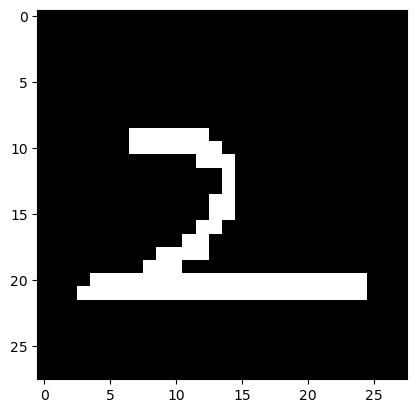

In [328]:
valid_accuracy(parameters)
# img = test_img[np.random.randint(1000)]
img = ImagePrepare("test")
print(get_answer(img, parameters))
plt.imshow(img.reshape(28,28), 'gray')
plt.show()

In [6]:
def distribute_coins():
    total_coins = 137
    for d in range(1, total_coins):
        for c_multiplier in range(2, total_coins):
            c = d * c_multiplier
            if c >= total_coins:
                break
            for b_multiplier in range(2, total_coins):
                b = c * b_multiplier
                if b >= total_coins:
                    break
                for a_multiplier in range(2, total_coins):
                    a = b * a_multiplier
                    if a >= total_coins:
                        break
                    if a + b + c + d == total_coins:
                        print(a, b, c, d)
    return None

print(distribute_coins())


120 12 4 1
88 44 4 1
112 16 8 1
96 32 8 1
None
